This code implements the DGME method proposed and analyzed in the paper ``DEEP BACKWARD AND GALERKIN METHODS FOR LEARNING FINITE
STATE MASTER EQUATIONS'' by Asaf Cohen, Mathieu Laurière and Ethan Zell.

The example solved here corresponds to Example 7.1 in the paper.

In [2]:
import tensorflow as tf
import numpy as np
import math, keras, random, copy
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import imageio
import copy
import matplotlib as mpl
import plotly.graph_objects as go

tf.random.set_seed(703)
np.random.seed(703)

In [3]:
# global, static parameters
d=2

In [4]:
class DGMDatasetGenerator4:
  '''
  A class that generates the dataset for the DGM.
  '''
  def __init__(self, d=d, horizon=1.):
    self.t_data = None
    self.x_data = None
    self.eta_data = None
    self.t_terminal_data = None
    self.x_terminal_data = None
    self.eta_terminal_data = None
    self.d = d
    self.horizon = horizon

  def uniformly_random_measure(self):
    '''
    Uses exponential random variables to generate a uniformly random probability vector.
    '''
    pre_normalized = np.random.exponential(1, size = (self.d,))
    return pre_normalized / sum(pre_normalized)

  def uniformly_random_measure_vec(self, samples):
    '''
    Vectorizes the prior function.
    '''
    data = np.zeros((samples, self.d))
    for k in range(samples):
      data[k,:] = self.uniformly_random_measure()
    return data

  def generate_dataset(self, samples=1000, terminal_samples = 100):

    '''
    Creates the dataset which, for the DGME, needs t, x, and eta data.
    '''

    t_data = np.random.uniform(0,self.horizon,size=samples)
    x_data = np.random.choice([float(m) for m in range(self.d)],size=samples)
    eta_data = self.uniformly_random_measure_vec(samples = samples)

    t_terminal_data = np.full(shape = (terminal_samples,), fill_value = self.horizon)
    x_terminal_data = np.random.choice([float(m) for m in range(self.d)], size=terminal_samples)
    eta_terminal_data = self.uniformly_random_measure_vec(samples = terminal_samples)

    self.t_data = t_data
    self.x_data = x_data
    self.eta_data = eta_data

    self.t_terminal_data = t_terminal_data
    self.x_terminal_data = x_terminal_data
    self.eta_terminal_data = eta_terminal_data

    return t_data, x_data, eta_data, t_terminal_data, x_terminal_data, eta_terminal_data

  def oversampling(self, oversample_T = True):
    '''
    Apply this function after generate_dataset to modify the domain of the sampled eta and T.
    Sampling outside the domain may improve performance along the domain's boundary.
    '''
    if oversample_T:
      terminal_samples = self.t_terminal_data.shape[0]

      random_mask = np.full(terminal_samples, False)
      random_mask[:int(terminal_samples * 0.5)] = True # this will make half of them oversampling
      np.random.shuffle(random_mask)

      self.t_terminal_data[random_mask == True] += np.random.uniform(0, self.horizon, size = int(terminal_samples * 0.5))

    return  self.t_data, self.x_data, self.eta_data, self.t_terminal_data, self.x_terminal_data, self.eta_terminal_data

  def data_to_tensors(self):

    self.t_data = tf.convert_to_tensor(self.t_data, dtype = 'float32')
    self.x_data = tf.convert_to_tensor(self.x_data, dtype = 'float32')
    self.eta_data = tf.convert_to_tensor(self.eta_data, dtype = 'float32')
    self.t_terminal_data = tf.convert_to_tensor(self.t_terminal_data, dtype = 'float32')
    self.x_terminal_data = tf.convert_to_tensor(self.x_terminal_data, dtype = 'float32')
    self.eta_terminal_data = tf.convert_to_tensor(self.eta_terminal_data, dtype = 'float32')

    return  self.t_data, self.x_data, self.eta_data, self.t_terminal_data, self.x_terminal_data, self.eta_terminal_data

In [5]:
class DGMModel(tf.keras.Model):
  '''
  This class defines the neural network model.
  '''
  def __init__(self, architecture):
    super(DGMModel, self).__init__()
    self.architecture = architecture # you can give a list specifying the number of nodes in each dense layer
    self.layer_list = []

    for i,number_of_nodes in enumerate(architecture):
      if i == 0:
        self.layer_list.append(tf.keras.layers.Dense(units=number_of_nodes, activation='sigmoid',
                                                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.),
                                                              bias_initializer='zeros'))
      else:
        self.layer_list.append(tf.keras.layers.Dense(units=number_of_nodes, activation='sigmoid',
                                                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.),
                                                              bias_initializer='zeros'))
    self.layer_list.append(tf.keras.layers.Dense(units=1, activation = 'elu'))

  def call(self, t , x, eta): # changed the concatenation because eta changed?
    t = tf.expand_dims(t, axis = -1)
    x = tf.expand_dims(x, axis = -1)
    input = tf.concat([t, x, eta], 1)
    result = input
    for layer in self.layer_list:
      result = layer(result)
    return result

Recall from the paper that we are interested in approximately solving the master equation:

$$
\partial_t U(t,x,\eta) = H(x,\Delta_x U(t,\cdot,\eta))+ F(x,\eta) + \sum_{y,z\in [d]} D^\eta_{yz} U(t,x,\eta) \gamma^*_z(y,\Delta_y U(t,\cdot,\eta)) \eta_y,
$$

where in this example:

$$F(x,\eta) = \eta_x,$$

$$H(x,p) := \min_{a} \Big\{\frac{1}{2}|a|^2 + a\cdot p\Big\},$$

and where $\gamma^*$ is the associated minimal argument that minimizes the Hamiltonian $H$. Recall that $\Delta_x b:= (b_y - b_x)_{y\in [d]}$ is a finite difference vector and $D^\eta_{yz}$ denotes the directional derivative in the $z$ minus $y$ direction (in terms of the standard basis).

In the Loss class below, $F$ is referred to as the mean_field_cost and $H$ is the Hamiltonian.

In [6]:
class Loss():
  '''
  This class defines the loss and involves the entire PDE.
  '''

  def __init__(self, model, d, a = 2., a_l = 1., a_u = 3., b = 4.):
    self.model = model
    self.d = d
    self.a = a
    self.a_l = a_l
    self.a_u = a_u
    self.b = b
    return

  def a_star(self, psi_left, psi_right):
    '''
    The computed value of $\gamma^*$, the minimal argument of the Hamiltonian. The paper derives this formula explicitly.
    '''
    numerator = psi_left - psi_right
    return ( numerator / ( (self.a_u - self.a_l) * self.b) ) + self.a

  def Hamiltonian_z1(self, x, z1_state_tensor, psi_output, psi_z1_output):
    '''
    The Hamiltonian, denoted H in the paper.
    '''
    a_star_z1 = self.a_star(psi_output, psi_z1_output)
    where_unequal = tf.cast(tf.math.logical_not(tf.math.equal(x, z1_state_tensor)), dtype = 'float32')
    pre_running = a_star_z1 - ( self.a * tf.ones(shape = a_star_z1.shape, dtype='float32') )
    running_cost = self.b * tf.multiply(tf.math.square(pre_running), where_unequal)
    change_of_state = tf.multiply(a_star_z1, (psi_z1_output - psi_output))
    return running_cost + change_of_state

  def interaction_sum_term_z1_z2(self, z1, z2, eta, eta_derivative, psi_z1, psi_z2):
    '''
    This is an individual term from the sum part of the PDE.
    '''
    mf = eta[:,int(z1)]
    directional_derivative = eta_derivative[:,int(z2)] - eta_derivative[:,int(z1)]
    control = self.a_star(psi_z1, psi_z2)
    result = tf.multiply(tf.multiply(mf, directional_derivative), control)
    return result

  def mean_field_cost(self, x, eta):
    '''
    The common cost, denoted F in the paper.
    '''
    mf = np.zeros(x.shape)
    for i,entry in enumerate(x):
      mf[i] = eta[i, int(entry)]
    mfc = tf.convert_to_tensor(mf, dtype='float32')
    return mfc

  def derivatives(self, t, x, eta):

    '''
    The time and measure derivatives are needed to compute the interaction_sum_term_z1_z2 function. This then goes into the sum term of the PDE.
    '''

    with tf.GradientTape(persistent=True) as tape:
      tape.watch(t)
      V = self.model(t,x,eta)
    time_derivative = tape.gradient(V,t)

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(eta)
        V = self.model(t,x,eta)
    eta_derivative = tape2.gradient(V,eta)

    self.time_derivative = time_derivative
    self.eta_derivative = eta_derivative

    return time_derivative, eta_derivative

  def criterion(self, t, x, eta):

    '''
    Combining all the prior terms into the loss. We need two for loops in order to compute the sum term.
    '''

    time_derivative, eta_derivative = self.derivatives(t, x, eta)
    output = tf.squeeze(self.model(t, x, eta))

    sum = tf.zeros(t.shape)
    for z1 in range(d):

      z1_state_tensor = z1 * tf.ones(shape = t.shape, dtype='float32')
      psi_z1 = tf.squeeze(self.model(t, z1_state_tensor, eta))
      sum += self.Hamiltonian_z1(x, z1_state_tensor, output, psi_z1)

      for z2 in range(d):

        z2_state_tensor = z2 * tf.ones(shape = t.shape, dtype='float32')
        psi_z2 = tf.squeeze(self.model(t, z2_state_tensor, eta))
        term = self.interaction_sum_term_z1_z2(z1, z2, eta, eta_derivative, psi_z1, psi_z2)
        sum += self.interaction_sum_term_z1_z2(z1, z2, eta, eta_derivative, psi_z1, psi_z2)

    mean_field_cost = self.mean_field_cost(x, eta)

    loss_sum = time_derivative + sum + mean_field_cost

    squared_loss = tf.math.square(loss_sum)

    return squared_loss # not yet reduced

  def terminal_criterion(self, t_terminal, x_terminal, eta_terminal):

    '''
    We have an additional function to compute the loss at the terminal time.
    '''

    terminal_output = tf.squeeze(self.model(t_terminal, x_terminal, eta_terminal))
    squared_terminal = tf.math.square(terminal_output)

    return squared_terminal

  def total_criterion(self, t, x, eta, t_terminal, x_terminal, eta_terminal, factor=1.):
    unreduced_loss = self.criterion(t, x, eta)
    unreduced_terminal_loss = self.terminal_criterion(t_terminal, x_terminal, eta_terminal)
    loss = tf.reduce_max(unreduced_loss)
    terminal_loss = tf.reduce_max(unreduced_terminal_loss)
    return loss + (factor * terminal_loss)


In [7]:
class SmallViz:
  def __init__(self, model, num_measure_points =1_000):
    self.model = model
    self.num_points = num_measure_points

  def single_graph_population_updated(self, t=0., x=0.):
    '''
    This function gets the values from the neural network, populated on the simplex. Only for d=2.
    '''
    two_simplex = np.linspace(start = 0, stop = 1, num = self.num_points, endpoint = True)
    eta_data = np.zeros((self.num_points, d))
    eta_data[:,0] = two_simplex
    eta_data[:,1] = 1. - two_simplex
    eta_data = tf.convert_to_tensor(eta_data, dtype='float32')
    t = tf.fill((self.num_points,), t)
    x = tf.fill((self.num_points,), x)
    y = self.model(t,x,eta_data)
    y_for_graph = y.numpy()[:,0]
    return two_simplex, y_for_graph

  def display_single_graph_updated(self, t=0., x=0.):
    '''
    Uses the prior function to graph the DGME neural network's values. Only for d=2.
    '''
    two_simplex, y_for_graph = self.single_graph_population_updated(t=t, x=x)
    fig, ax = plt.subplots(figsize=(6, 4)) #, tight_layout=True)
    ax.set_ylim([0,1])
    ax.plot(two_simplex, y_for_graph)
    ax.set_xlabel(f'$\mu(x=1)$')
    ax.set_ylabel(f'$U(t={round(t,2)},x={int(x)+1},\eta=\mu)$')
    ax.set_title(r'')
    ax.plot(two_simplex, y_for_graph, color = 'black')
    return


  def display_graph_rainbow_updated(self, x=0., num_times = 15, T = 1.):
    '''
    Displays the DGME result but at multiple times. Only for d=2.
    '''
    fig, ax = plt.subplots(figsize=(6, 4)) #, tight_layout=True)
    ax.set_ylim([-0.01,0.34])
    ax.set_xlabel(f'$\mu(x=1)$')
    ax.set_ylabel('')
    ax.set_title(f'$U(x={int(x)+1}, \eta=\mu)$')

    time_points = np.linspace(0,T, num = num_times, endpoint = True)

    color = cm.rainbow(time_points)

    for k, c in enumerate(color):
      two_simplex, y_for_graph = self.single_graph_population_updated(t=time_points[k], x=x)
      if k == 0:
        ax.set_ylim([-0.01,max(y_for_graph)*1.05])
      ax.plot(two_simplex, y_for_graph, color = c, label = f't={round(time_points[k],2)}')

    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    return


In [8]:
class Train():
  def __init__(self, model, dataset_generator, b=1., factor = 1., oversampling = True, return_losses = False, verbose = False, visual_output = False):
    self.model = model
    self.dsg = dataset_generator
    self.return_losses = return_losses
    self.losses = []
    self.verbose = verbose
    self.visual_output = visual_output
    self.factor = factor
    self.b = b

  def loss_gradient(self):
    loss_fn = Loss(model = self.model, d = d, b=self.b)
    with tf.GradientTape(persistent=True) as loss_tape:
      loss = loss_fn.total_criterion(self.t, self.x, self.eta, self.t_T, self.x_T, self.eta_T, factor = self.factor)
    return loss, loss_tape.gradient(loss, self.model.trainable_variables)

  def step(self, optimizer):

    '''
    A single step in the training regime of the neural network.
    '''

    loss, loss_grad = self.loss_gradient()

    if self.verbose:
      self.avg_losses.append(loss.numpy())

    if self.return_losses:
      self.losses.append(loss)

    optimizer.apply_gradients(zip(loss_grad, self.model.trainable_variables))
    return self.model

  def train_nn(self, epochs, steps_per_epoch, learning_rate = 1e-3, verbose=False):

    '''
    The main training function to train the neural network.
    '''

    print('Training the DGME network.')

    lr_fn = tf.optimizers.schedules.PolynomialDecay(initial_learning_rate=learning_rate, decay_steps = int(epochs*steps_per_epoch),
                                                    end_learning_rate=1e-6, power = 0.9)
    opt = tf.keras.optimizers.Adam(lr_fn)

    for m in range(epochs):

      self.avg_losses = []

      self.dsg.generate_dataset()
      self.dsg.oversampling()
      self.t, self.x, self.eta, self.t_T, self.x_T, self.eta_T, = self.dsg.data_to_tensors()

      for step in range(steps_per_epoch):

        self.model = self.step(opt)

      if self.verbose:
        print(f'Avg loss for epoch {m} was: {np.mean(self.avg_losses)}')

      if m %5 == 0:
        if self.visual_output:
          viz = SmallViz(model = self.model)
          viz.display_graph_rainbow_updated()
          plt.show()
          plt.clf()


    self.model.save_weights('dgm_weights')

    if self.return_losses:
      return self.model, self.losses
    return self.model

Training the DGME network.


Avg loss for epoch 0 was: 0.8993957042694092


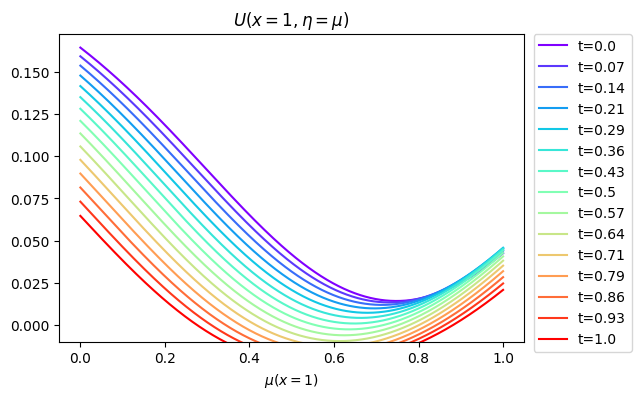

Avg loss for epoch 1 was: 0.4093756079673767
Avg loss for epoch 2 was: 0.32137739658355713
Avg loss for epoch 3 was: 0.2922181487083435
Avg loss for epoch 4 was: 0.2698969542980194
Avg loss for epoch 5 was: 0.24205294251441956


<Figure size 640x480 with 0 Axes>

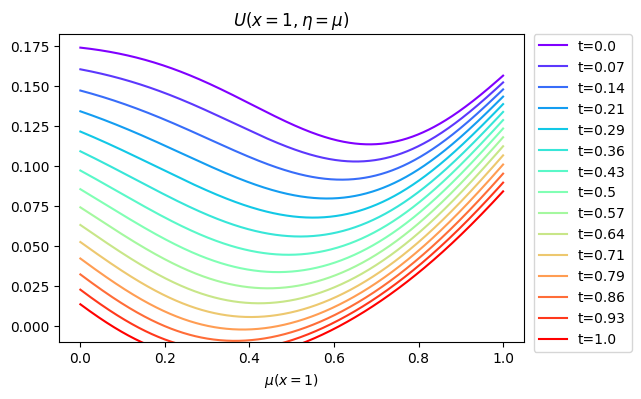

Avg loss for epoch 6 was: 0.2459452897310257
Avg loss for epoch 7 was: 0.22302350401878357
Avg loss for epoch 8 was: 0.2101692408323288
Avg loss for epoch 9 was: 0.21337155997753143
Avg loss for epoch 10 was: 0.21107251942157745


<Figure size 640x480 with 0 Axes>

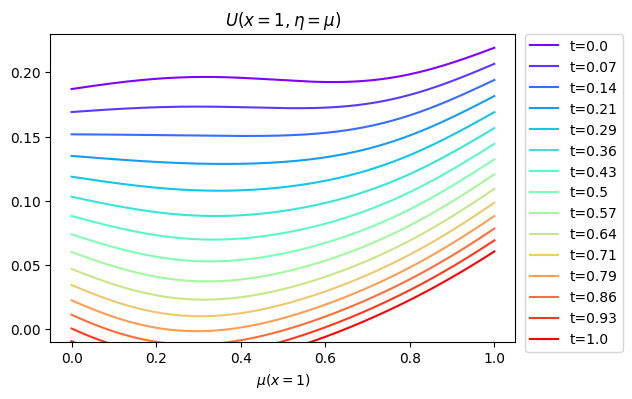

Avg loss for epoch 11 was: 0.20491765439510345
Avg loss for epoch 12 was: 0.19189079105854034
Avg loss for epoch 13 was: 0.2002316266298294
Avg loss for epoch 14 was: 0.19277532398700714
Avg loss for epoch 15 was: 0.18843413889408112


<Figure size 640x480 with 0 Axes>

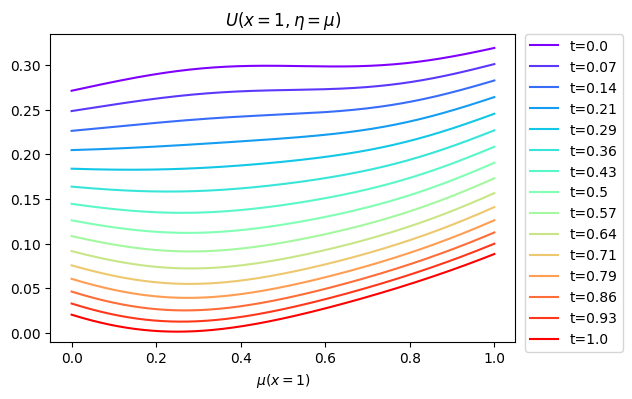

Avg loss for epoch 16 was: 0.18293072283267975
Avg loss for epoch 17 was: 0.18326331675052643
Avg loss for epoch 18 was: 0.17205825448036194
Avg loss for epoch 19 was: 0.16933900117874146
Avg loss for epoch 20 was: 0.17185236513614655


<Figure size 640x480 with 0 Axes>

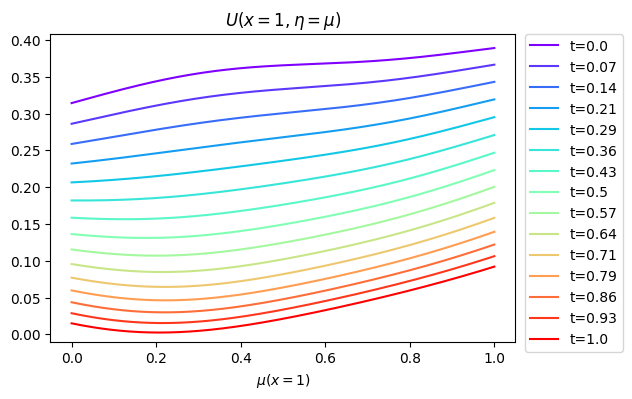

Avg loss for epoch 21 was: 0.17130360007286072
Avg loss for epoch 22 was: 0.15164116024971008
Avg loss for epoch 23 was: 0.15576805174350739
Avg loss for epoch 24 was: 0.1638842076063156
Avg loss for epoch 25 was: 0.1458830088376999


<Figure size 640x480 with 0 Axes>

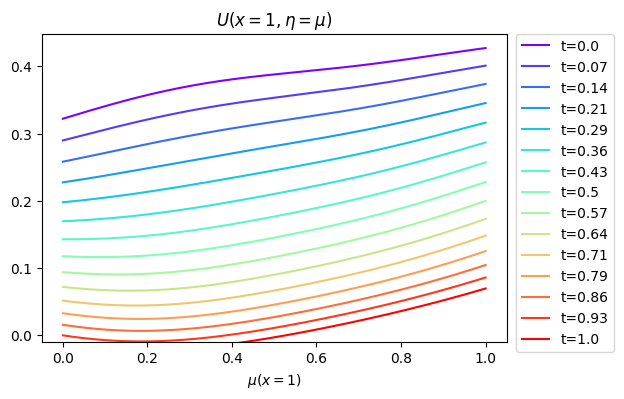

Avg loss for epoch 26 was: 0.14289477467536926
Avg loss for epoch 27 was: 0.13478343188762665
Avg loss for epoch 28 was: 0.13411001861095428
Avg loss for epoch 29 was: 0.12037716805934906
Avg loss for epoch 30 was: 0.14173921942710876


<Figure size 640x480 with 0 Axes>

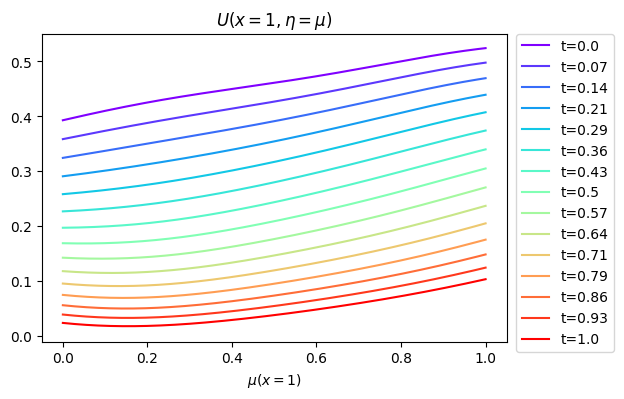

Avg loss for epoch 31 was: 0.12870199978351593
Avg loss for epoch 32 was: 0.11571402847766876
Avg loss for epoch 33 was: 0.12560470402240753
Avg loss for epoch 34 was: 0.11936941742897034
Avg loss for epoch 35 was: 0.10323449969291687


<Figure size 640x480 with 0 Axes>

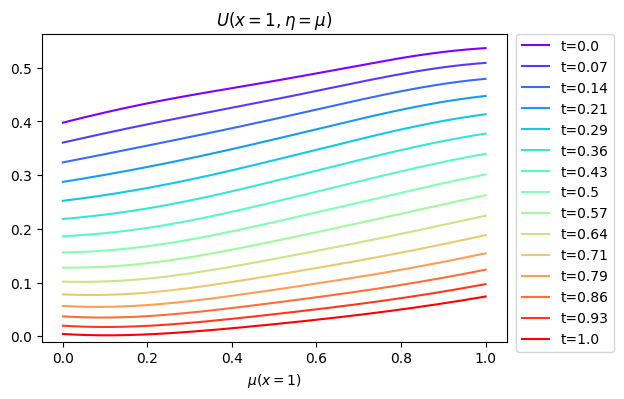

Avg loss for epoch 36 was: 0.11807392537593842
Avg loss for epoch 37 was: 0.11450298130512238
Avg loss for epoch 38 was: 0.10358573496341705
Avg loss for epoch 39 was: 0.10856916010379791
Avg loss for epoch 40 was: 0.1084320917725563


<Figure size 640x480 with 0 Axes>

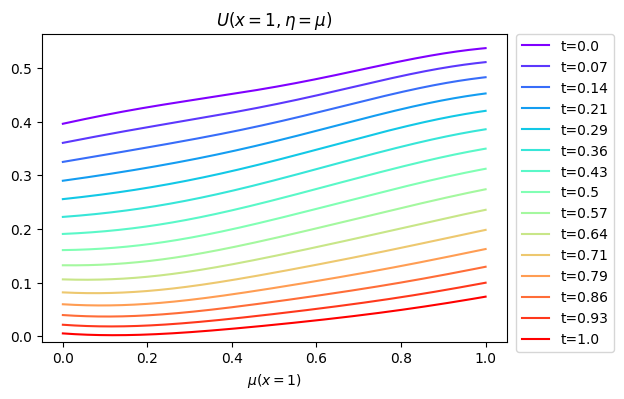

Avg loss for epoch 41 was: 0.09932820498943329
Avg loss for epoch 42 was: 0.11072372645139694
Avg loss for epoch 43 was: 0.09009990096092224
Avg loss for epoch 44 was: 0.09531167149543762
Avg loss for epoch 45 was: 0.08798014372587204


<Figure size 640x480 with 0 Axes>

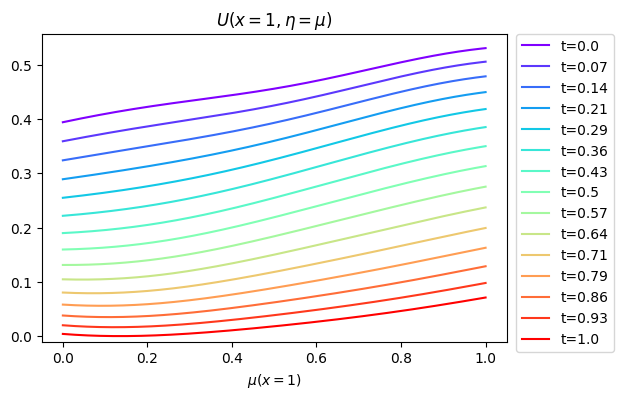

Avg loss for epoch 46 was: 0.10391994565725327
Avg loss for epoch 47 was: 0.0910571813583374
Avg loss for epoch 48 was: 0.0942857563495636
Avg loss for epoch 49 was: 0.08941754698753357
Avg loss for epoch 50 was: 0.07822350412607193


<Figure size 640x480 with 0 Axes>

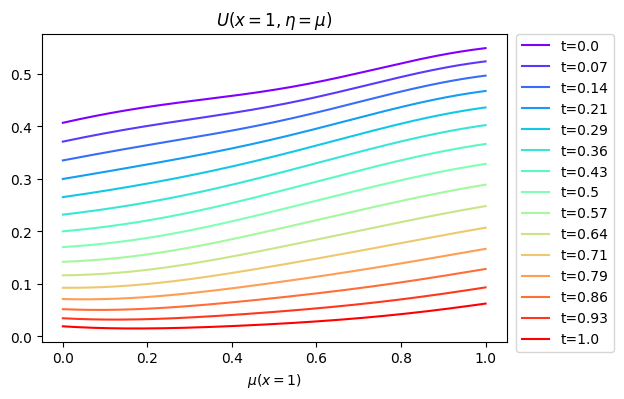

Avg loss for epoch 51 was: 0.08639144897460938
Avg loss for epoch 52 was: 0.08111823350191116
Avg loss for epoch 53 was: 0.08512332290410995
Avg loss for epoch 54 was: 0.07945329695940018
Avg loss for epoch 55 was: 0.06628267467021942


<Figure size 640x480 with 0 Axes>

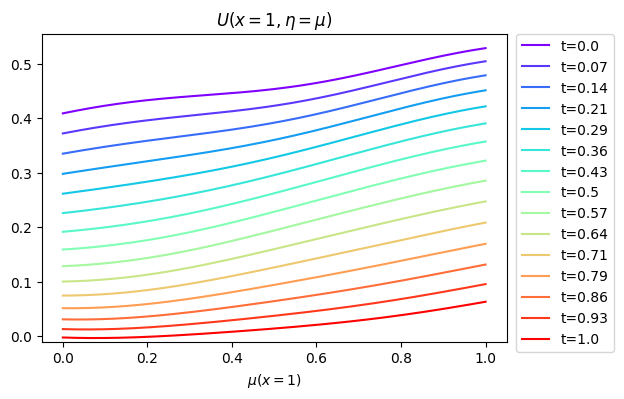

Avg loss for epoch 56 was: 0.067909836769104
Avg loss for epoch 57 was: 0.06400939077138901
Avg loss for epoch 58 was: 0.06605546176433563
Avg loss for epoch 59 was: 0.06106707081198692
Avg loss for epoch 60 was: 0.059448521584272385


<Figure size 640x480 with 0 Axes>

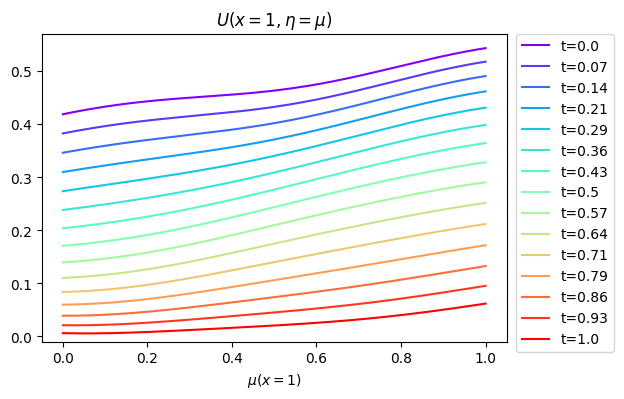

Avg loss for epoch 61 was: 0.05812428146600723
Avg loss for epoch 62 was: 0.05609944835305214
Avg loss for epoch 63 was: 0.059227488934993744
Avg loss for epoch 64 was: 0.0439772866666317
Avg loss for epoch 65 was: 0.046717144548892975


<Figure size 640x480 with 0 Axes>

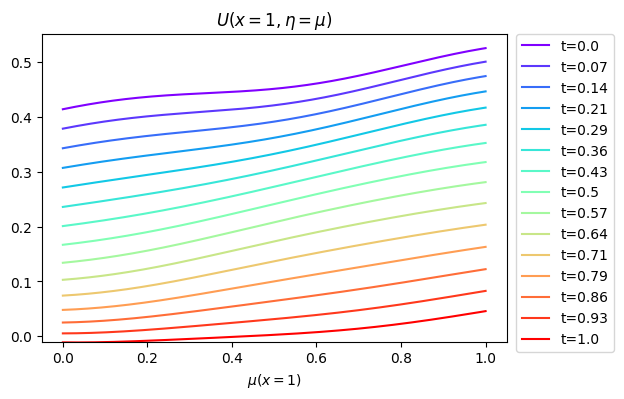

Avg loss for epoch 66 was: 0.04854957386851311
Avg loss for epoch 67 was: 0.041637517511844635
Avg loss for epoch 68 was: 0.040528859943151474
Avg loss for epoch 69 was: 0.04280408099293709
Avg loss for epoch 70 was: 0.04129256308078766


<Figure size 640x480 with 0 Axes>

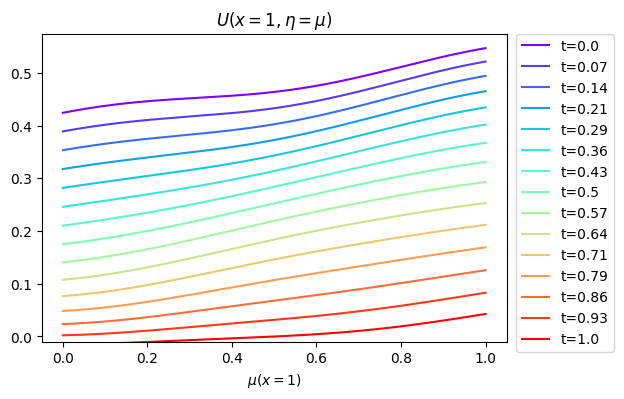

Avg loss for epoch 71 was: 0.039145294576883316
Avg loss for epoch 72 was: 0.03774096071720123
Avg loss for epoch 73 was: 0.04405202716588974
Avg loss for epoch 74 was: 0.03979339450597763
Avg loss for epoch 75 was: 0.03535618633031845


<Figure size 640x480 with 0 Axes>

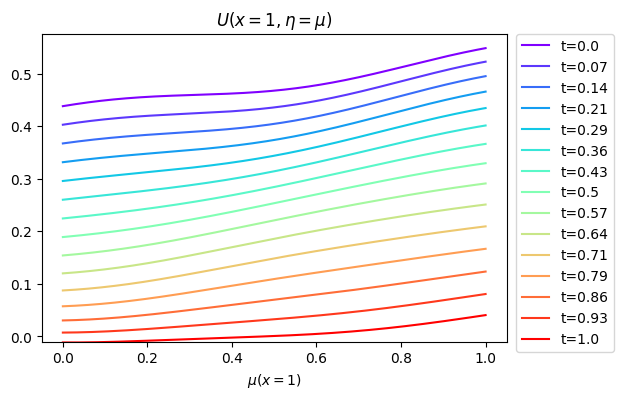

Avg loss for epoch 76 was: 0.03577949479222298
Avg loss for epoch 77 was: 0.040603555738925934
Avg loss for epoch 78 was: 0.0362231582403183
Avg loss for epoch 79 was: 0.03100656159222126
Avg loss for epoch 80 was: 0.03321386128664017


<Figure size 640x480 with 0 Axes>

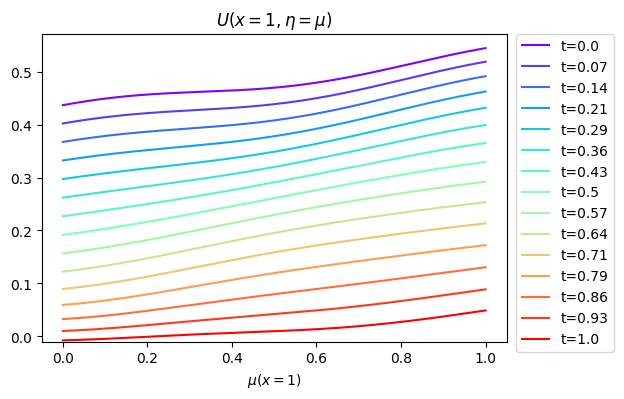

Avg loss for epoch 81 was: 0.03542644903063774
Avg loss for epoch 82 was: 0.03759393468499184
Avg loss for epoch 83 was: 0.034518055617809296
Avg loss for epoch 84 was: 0.03175123408436775
Avg loss for epoch 85 was: 0.031092574819922447


<Figure size 640x480 with 0 Axes>

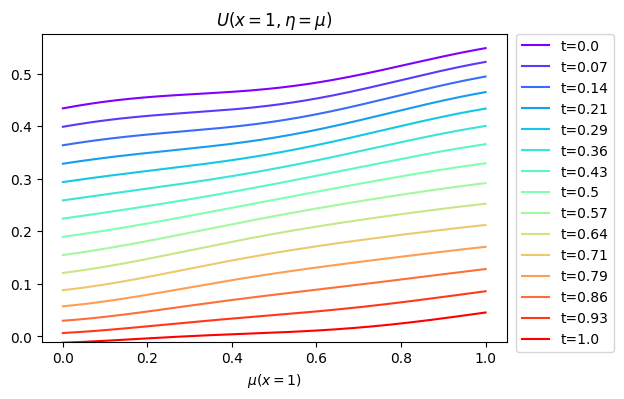

Avg loss for epoch 86 was: 0.031048843637108803
Avg loss for epoch 87 was: 0.0273286160081625
Avg loss for epoch 88 was: 0.029974061995744705
Avg loss for epoch 89 was: 0.031967394053936005
Avg loss for epoch 90 was: 0.03299816697835922


<Figure size 640x480 with 0 Axes>

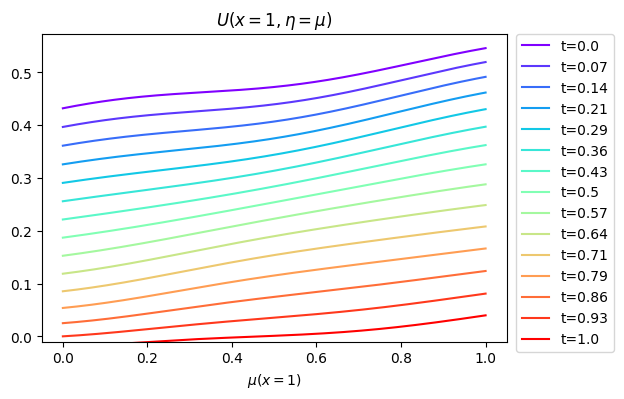

Avg loss for epoch 91 was: 0.028545651584863663
Avg loss for epoch 92 was: 0.02930394373834133
Avg loss for epoch 93 was: 0.0275234654545784
Avg loss for epoch 94 was: 0.029972732067108154
Avg loss for epoch 95 was: 0.027596857398748398


<Figure size 640x480 with 0 Axes>

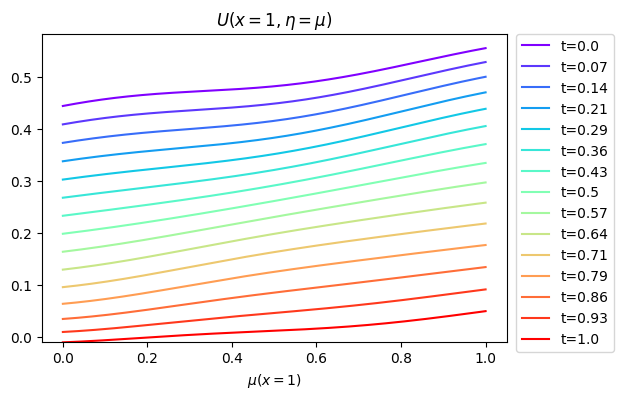

Avg loss for epoch 96 was: 0.027325697243213654
Avg loss for epoch 97 was: 0.02605332061648369
Avg loss for epoch 98 was: 0.026060722768306732
Avg loss for epoch 99 was: 0.02741270698606968
Avg loss for epoch 100 was: 0.027705220505595207


<Figure size 640x480 with 0 Axes>

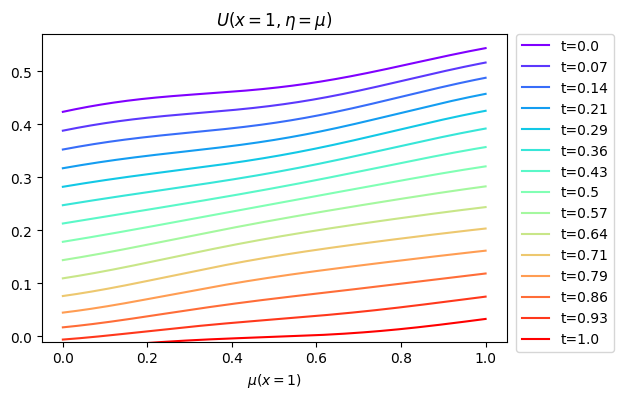

Avg loss for epoch 101 was: 0.025271808728575706
Avg loss for epoch 102 was: 0.02890242263674736
Avg loss for epoch 103 was: 0.0256618931889534
Avg loss for epoch 104 was: 0.025893619284033775
Avg loss for epoch 105 was: 0.028218822553753853


<Figure size 640x480 with 0 Axes>

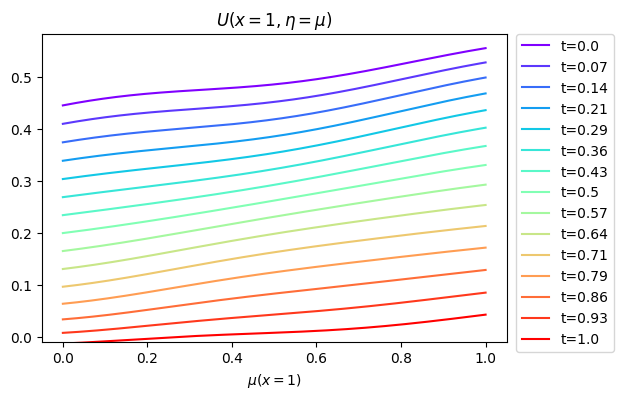

Avg loss for epoch 106 was: 0.026512496173381805
Avg loss for epoch 107 was: 0.021658392623066902
Avg loss for epoch 108 was: 0.026520418003201485
Avg loss for epoch 109 was: 0.02483648620545864
Avg loss for epoch 110 was: 0.023087691515684128


<Figure size 640x480 with 0 Axes>

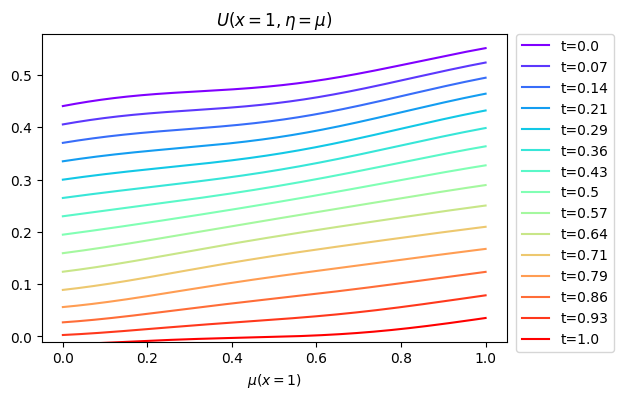

Avg loss for epoch 111 was: 0.02569124661386013
Avg loss for epoch 112 was: 0.026317546144127846
Avg loss for epoch 113 was: 0.024121155962347984
Avg loss for epoch 114 was: 0.02763732150197029
Avg loss for epoch 115 was: 0.02297445945441723


<Figure size 640x480 with 0 Axes>

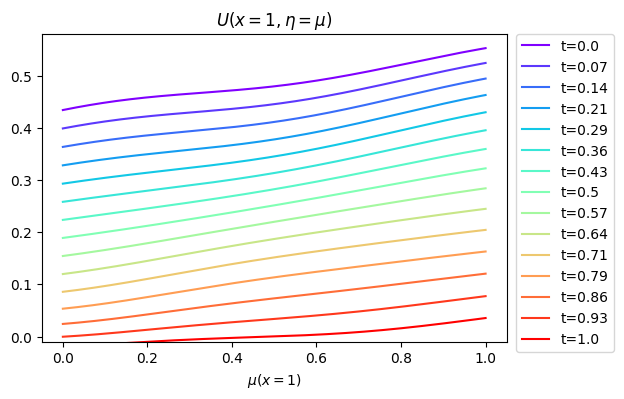

Avg loss for epoch 116 was: 0.022103596478700638
Avg loss for epoch 117 was: 0.026332957670092583
Avg loss for epoch 118 was: 0.022608887404203415
Avg loss for epoch 119 was: 0.023576769977808
Avg loss for epoch 120 was: 0.025692377239465714


<Figure size 640x480 with 0 Axes>

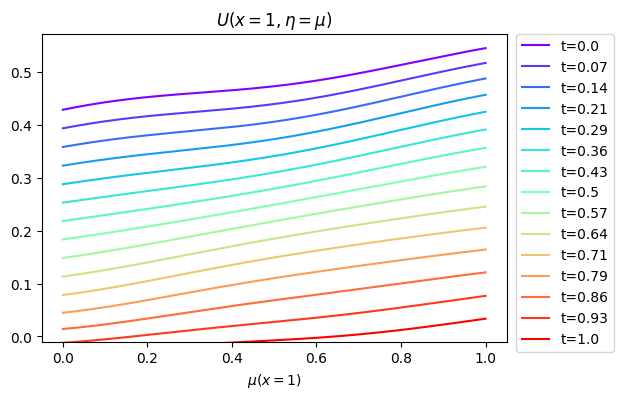

Avg loss for epoch 121 was: 0.02457055263221264
Avg loss for epoch 122 was: 0.022876519709825516
Avg loss for epoch 123 was: 0.023113097995519638
Avg loss for epoch 124 was: 0.025136858224868774
Avg loss for epoch 125 was: 0.021162310615181923


<Figure size 640x480 with 0 Axes>

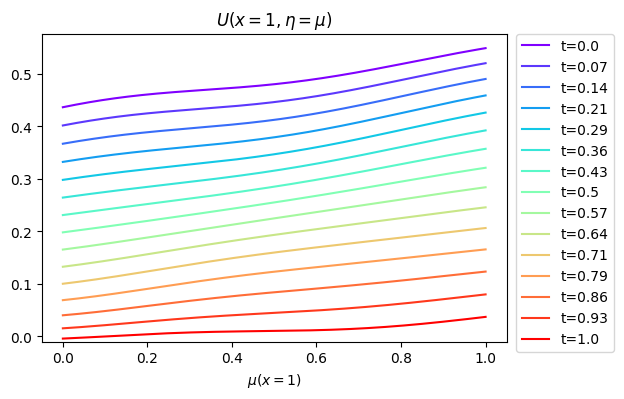

Avg loss for epoch 126 was: 0.025293204933404922
Avg loss for epoch 127 was: 0.02059423178434372
Avg loss for epoch 128 was: 0.01857732981443405
Avg loss for epoch 129 was: 0.022669512778520584
Avg loss for epoch 130 was: 0.022787783294916153


<Figure size 640x480 with 0 Axes>

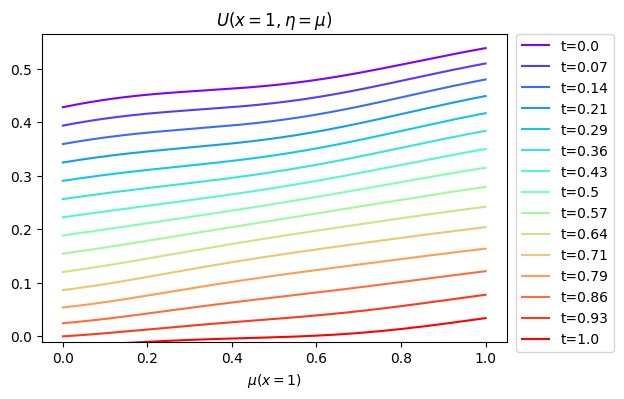

Avg loss for epoch 131 was: 0.02064792439341545
Avg loss for epoch 132 was: 0.023234758526086807
Avg loss for epoch 133 was: 0.024879474192857742
Avg loss for epoch 134 was: 0.0227434653788805
Avg loss for epoch 135 was: 0.023048514500260353


<Figure size 640x480 with 0 Axes>

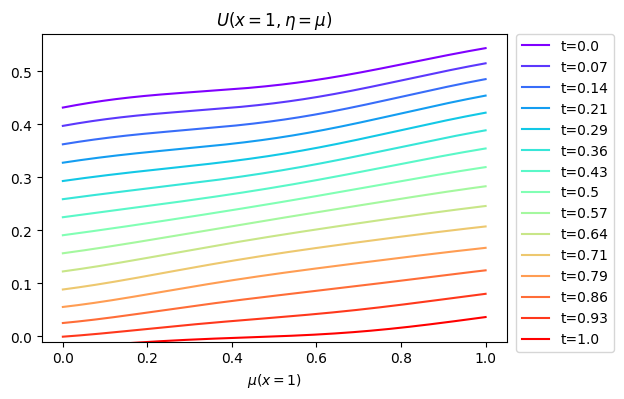

Avg loss for epoch 136 was: 0.01869567669928074
Avg loss for epoch 137 was: 0.020506467670202255
Avg loss for epoch 138 was: 0.025722913444042206
Avg loss for epoch 139 was: 0.020380837842822075
Avg loss for epoch 140 was: 0.021130530163645744


<Figure size 640x480 with 0 Axes>

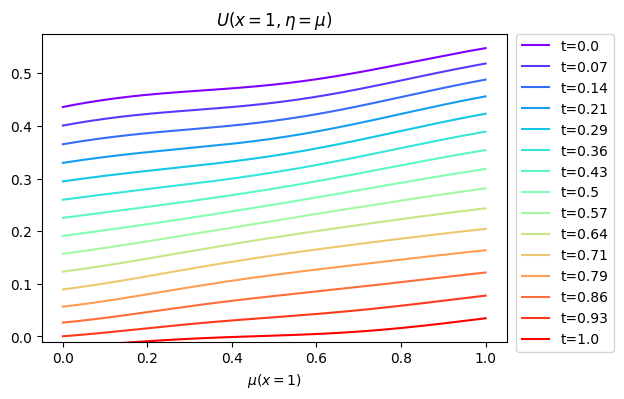

Avg loss for epoch 141 was: 0.023044537752866745
Avg loss for epoch 142 was: 0.02083137072622776
Avg loss for epoch 143 was: 0.025032736361026764
Avg loss for epoch 144 was: 0.0213332399725914
Avg loss for epoch 145 was: 0.022921493276953697


<Figure size 640x480 with 0 Axes>

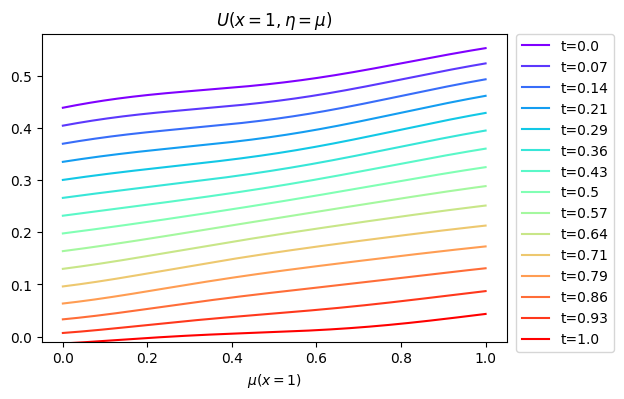

Avg loss for epoch 146 was: 0.02136942930519581
Avg loss for epoch 147 was: 0.021517906337976456
Avg loss for epoch 148 was: 0.019709600135684013
Avg loss for epoch 149 was: 0.017894160002470016
Avg loss for epoch 150 was: 0.02179606817662716


<Figure size 640x480 with 0 Axes>

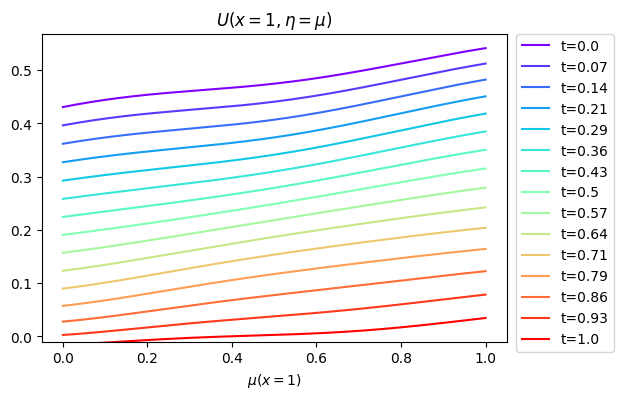

Avg loss for epoch 151 was: 0.020022569224238396
Avg loss for epoch 152 was: 0.022369736805558205
Avg loss for epoch 153 was: 0.021934324875473976
Avg loss for epoch 154 was: 0.020793315023183823
Avg loss for epoch 155 was: 0.018861856311559677


<Figure size 640x480 with 0 Axes>

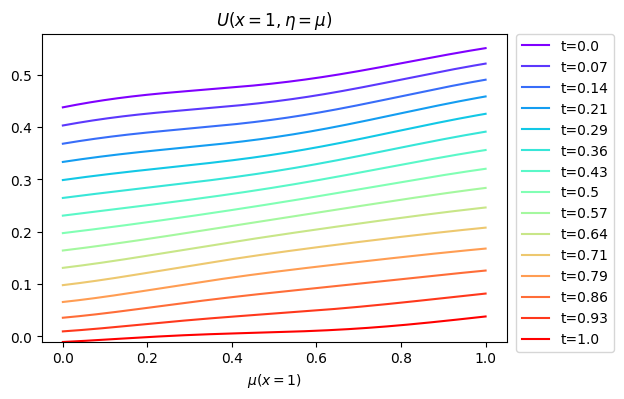

Avg loss for epoch 156 was: 0.021785203367471695
Avg loss for epoch 157 was: 0.020594775676727295
Avg loss for epoch 158 was: 0.018708279356360435
Avg loss for epoch 159 was: 0.019086677581071854
Avg loss for epoch 160 was: 0.018691862002015114


<Figure size 640x480 with 0 Axes>

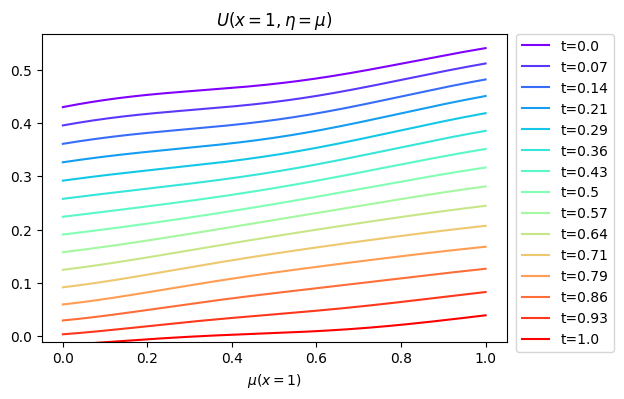

Avg loss for epoch 161 was: 0.019796473905444145
Avg loss for epoch 162 was: 0.019582873210310936
Avg loss for epoch 163 was: 0.019868256524205208
Avg loss for epoch 164 was: 0.02021127939224243
Avg loss for epoch 165 was: 0.01914234831929207


<Figure size 640x480 with 0 Axes>

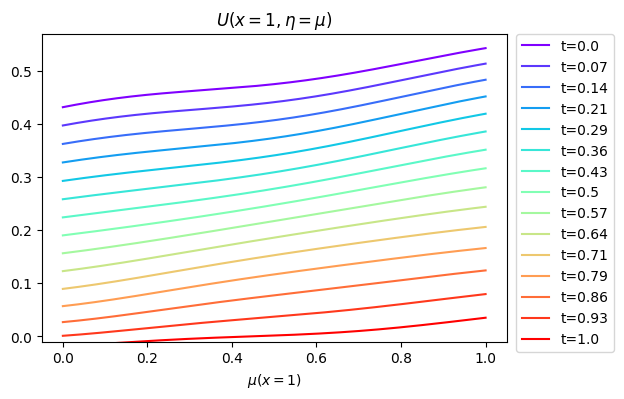

Avg loss for epoch 166 was: 0.020477723330259323
Avg loss for epoch 167 was: 0.016975613310933113
Avg loss for epoch 168 was: 0.019040333107113838
Avg loss for epoch 169 was: 0.018326548859477043
Avg loss for epoch 170 was: 0.018716514110565186


<Figure size 640x480 with 0 Axes>

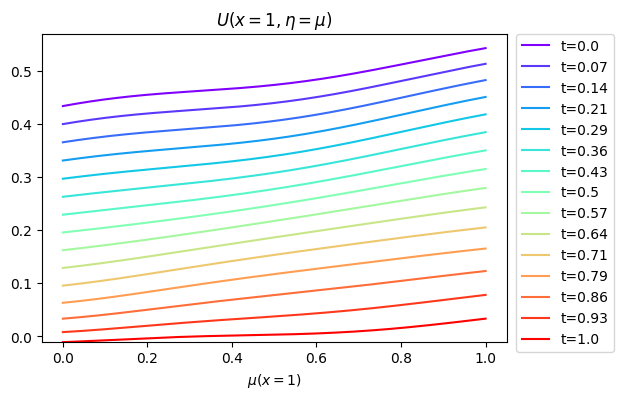

Avg loss for epoch 171 was: 0.017704274505376816
Avg loss for epoch 172 was: 0.017368117347359657
Avg loss for epoch 173 was: 0.0187959186732769
Avg loss for epoch 174 was: 0.016565101221203804
Avg loss for epoch 175 was: 0.01954355463385582


<Figure size 640x480 with 0 Axes>

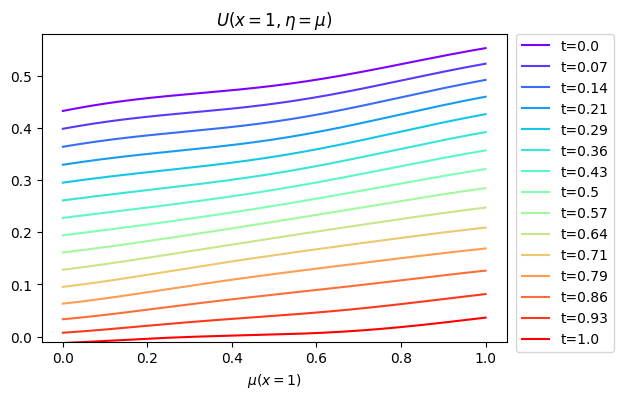

Avg loss for epoch 176 was: 0.018024832010269165
Avg loss for epoch 177 was: 0.01689975894987583
Avg loss for epoch 178 was: 0.017009852454066277
Avg loss for epoch 179 was: 0.018373709172010422
Avg loss for epoch 180 was: 0.018818944692611694


<Figure size 640x480 with 0 Axes>

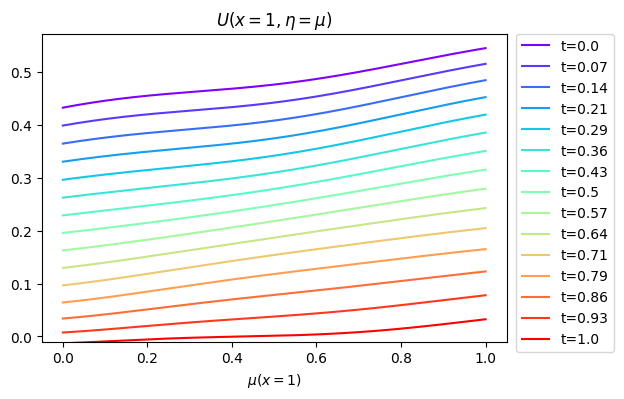

Avg loss for epoch 181 was: 0.016740994527935982
Avg loss for epoch 182 was: 0.019615719094872475
Avg loss for epoch 183 was: 0.015436026267707348
Avg loss for epoch 184 was: 0.018649721518158913
Avg loss for epoch 185 was: 0.016282815486192703


<Figure size 640x480 with 0 Axes>

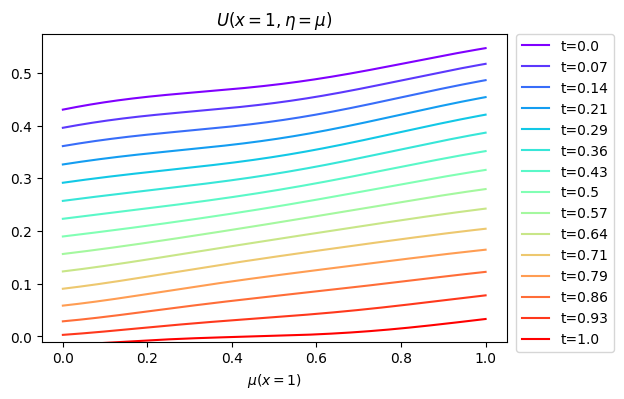

Avg loss for epoch 186 was: 0.018105890601873398
Avg loss for epoch 187 was: 0.01749798096716404
Avg loss for epoch 188 was: 0.017306851223111153
Avg loss for epoch 189 was: 0.017961736768484116
Avg loss for epoch 190 was: 0.017610425129532814


<Figure size 640x480 with 0 Axes>

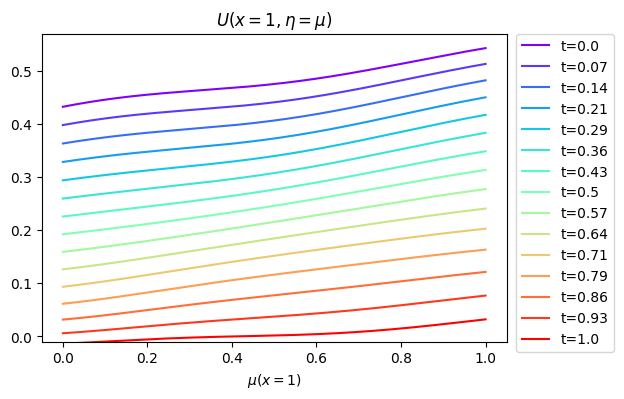

Avg loss for epoch 191 was: 0.017790893092751503
Avg loss for epoch 192 was: 0.0163394957780838
Avg loss for epoch 193 was: 0.018120072782039642
Avg loss for epoch 194 was: 0.01706058159470558
Avg loss for epoch 195 was: 0.01785525120794773


<Figure size 640x480 with 0 Axes>

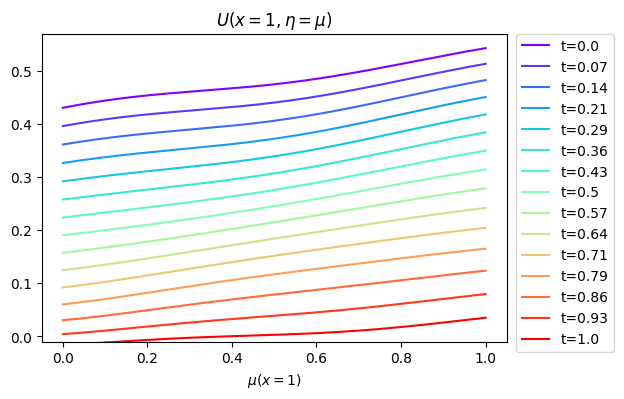

Avg loss for epoch 196 was: 0.015121656470000744
Avg loss for epoch 197 was: 0.01791992038488388
Avg loss for epoch 198 was: 0.016095053404569626
Avg loss for epoch 199 was: 0.016759531572461128


<Figure size 640x480 with 0 Axes>

In [9]:
trainer = Train(model = DGMModel([d+2,60,60,60,60]), dataset_generator = DGMDatasetGenerator4(d=d), factor = 10., verbose=True, visual_output = True)
trainer.train_nn(epochs = 200, steps_per_epoch= 30, learning_rate = 1e-3)
# save whole model
trainer.model.save(f'model_tf', save_format = 'tf')